# Anomaly Detection in Multivariate Time Series 

This notebook demonstrates the implementation of a stacked transformer encoder model for anomaly detection in multivariate time series data, specifically using the Server Machine Dataset (SMD).

## 1. Import Libraries and Load Data

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import pandas as pd
import glob
import os
import numpy as np
import torch
import torch.nn as nn
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm

In [3]:
# Load the SMD dataset
train_path = '/kaggle/input/smd-onmiad/ServerMachineDataset/train'
all_files = glob.glob(os.path.join(train_path, 'machine-1-*.txt'))

df_list = []
for file in all_files:
    df = pd.read_csv(file, header=None)
    machine_id = os.path.basename(file).split('-')[1].split('.')[0]
    df['machine_id'] = machine_id
    df_list.append(df)

combined_df = pd.concat(df_list, ignore_index=True)
print(combined_df.head())
combined_df.to_csv('df.csv', index=False)

ValueError: No objects to concatenate

## 2. Data Preprocessing

In [23]:
def preprocess_data(df):
    # Handle missing values
    df = df.fillna(method='ffill').fillna(method='bfill')
    
    # Normalize data using MinMax scaling
    scaler = MinMaxScaler()
    df_scaled = pd.DataFrame(scaler.fit_transform(df.drop('machine_id', axis=1)), columns=df.columns[:-1])
    df_scaled['machine_id'] = df['machine_id']
    
    # Cap outliers
    for col in df_scaled.columns[:-1]:
        mean = df_scaled[col].mean()
        std = df_scaled[col].std()
        df_scaled[col] = df_scaled[col].clip(mean - 3*std, mean + 3*std)
    
    return df_scaled

preprocessed_df = preprocess_data(combined_df)
print(preprocessed_df.head())

/tmp/ipykernel_34/3006942310.py:3: FutureWarning: DataFrame.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  df = df.fillna(method='ffill').fillna(method='bfill')


          0         1         2         3    4         5         6    7  \
0  0.032258  0.039195  0.027871  0.024390  0.0  0.915385  0.343691  0.0   
1  0.043011  0.048729  0.033445  0.025552  0.0  0.915385  0.344633  0.0   
2  0.043011  0.034958  0.032330  0.025552  0.0  0.915385  0.344633  0.0   
3  0.032258  0.028602  0.030100  0.024390  0.0  0.912821  0.342750  0.0   
4  0.032258  0.019068  0.026756  0.023229  0.0  0.912821  0.342750  0.0   

          8         9  ...        29        30        31   32        33  \
0  0.020011  0.000122  ...  0.004298  0.029993  0.022131  0.0  0.000045   
1  0.019160  0.001722  ...  0.004298  0.030041  0.028821  0.0  0.000045   
2  0.020011  0.000122  ...  0.004298  0.026248  0.021101  0.0  0.000045   
3  0.021289  0.000000  ...  0.004298  0.030169  0.025733  0.0  0.000022   
4  0.018734  0.000000  ...  0.004298  0.027240  0.022645  0.0  0.000034   

         34        35   36   37  machine_id  
0  0.034677  0.034747  0.0  0.0           1  
1  0.0

### Comparison of F1 Scores with only Fixed (FPE) and FPE + Learnable Positional Embeddings (LPE)
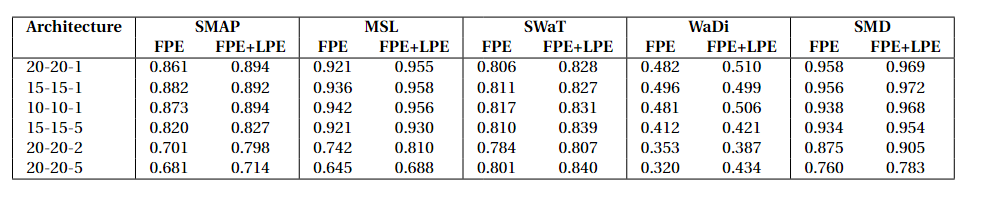

### Performance Comparison of Different Methods
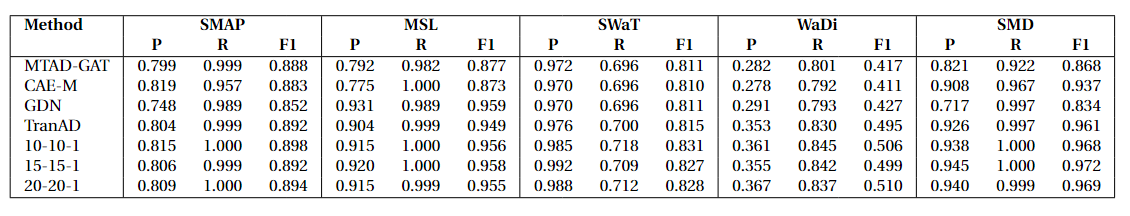

In [40]:
class FixedPositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(FixedPositionalEncoding, self).__init__()
        pe = torch.zeros(max_len, d_model)
        position = torch.arange(0, max_len, dtype=torch.float).unsqueeze(1)
        div_term = torch.exp(torch.arange(0, d_model, 2).float() * (-np.log(10000.0) / d_model))
        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)
        pe = pe.unsqueeze(0).transpose(0, 1)
        self.register_buffer('pe', pe)

    def forward(self, x):
        return x + self.pe[:x.size(0), :]

class LearnablePositionalEncoding(nn.Module):
    def __init__(self, d_model, max_len=5000):
        super(LearnablePositionalEncoding, self).__init__()
        self.pe = nn.Parameter(torch.zeros(1, max_len, d_model))  # Create learnable positional encodings

    def forward(self, x):
        # x has shape (batch_size, seq_len, d_model)
        # self.pe should be (1, seq_len, d_model) to match x
        seq_len = x.size(1)
        return x + self.pe[:, :seq_len, :]


class TRAN_ENC(nn.Module):
    def __init__(self, n_features, window_size, out_dim, n_head_f, n_head_t, dropout=0.1):
        super(TRAN_ENC, self).__init__()
        
        self.d_model = ((n_features // n_head_f) + 1) * n_head_f  # Round up to nearest multiple of n_head_f
        self.input_projection = nn.Linear(n_features, self.d_model)
        
        # Positional encodings for the feature and time branches
        self.fixed_pos_encoder = FixedPositionalEncoding(self.d_model)
        self.learnable_pos_encoder = LearnablePositionalEncoding(self.d_model)
        
        # Transformer encoders for feature and time
        self.feature_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=self.d_model, nhead=n_head_f, dropout=dropout),
            num_layers=3
        )
        
        self.time_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=window_size, nhead=n_head_t, dropout=dropout),
            num_layers=3
        )
        
        # Output encoder for the combined embeddings
        self.output_encoder = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=3*self.d_model, nhead=3*n_head_f, dropout=dropout),
            num_layers=1
        )
        
        # Separate linear layers for forecasting and reconstruction
        self.fc_forecast = nn.Linear(3*self.d_model, out_dim)
        self.fc_reconstruct = nn.Linear(3*self.d_model, out_dim)

    def forward(self, x):
        x = self.input_projection(x)
        
        # Apply positional encoding to the feature and time branches
        x_feat = self.fixed_pos_encoder(x)
        x_time = self.learnable_pos_encoder(x)
        
        # Feature-level encoding
        h_feat = self.feature_encoder(x_feat)
        
        # Time-level encoding
        h_temp = self.time_encoder(x_time.transpose(1, 2)).transpose(1, 2)
        
        # Concatenate original input with feature and time encodings
        h_cat = torch.cat([x, h_feat, h_temp], dim=2)
        
        # Output-level encoding
        h_out = self.output_encoder(h_cat)
        
        # Separate outputs for forecasting and reconstruction
        out_forecast = self.fc_forecast(h_out[:, -1, :])  # Use the last time step
        out_reconstruct = self.fc_reconstruct(h_out[:, -1, :])  # Use the last time step
        
        return out_forecast, out_reconstruct

n_features = 37  
window_size = 100
out_dim = n_features
n_head_f = 4
n_head_t = 4

model = TRAN_ENC(n_features, window_size, out_dim, n_head_f, n_head_t)
print(model)




TRAN_ENC(
  (input_projection): Linear(in_features=37, out_features=40, bias=True)
  (fixed_pos_encoder): FixedPositionalEncoding()
  (learnable_pos_encoder): LearnablePositionalEncoding()
  (feature_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=40, out_features=40, bias=True)
        )
        (linear1): Linear(in_features=40, out_features=2048, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=2048, out_features=40, bias=True)
        (norm1): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((40,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (time_encoder): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLay

## 4.Training the model

In [42]:
# Preparing the data
X = preprocessed_df.drop(['machine_id'], axis=1).values  # Dropping machine_id, assuming it's not used as a feature

# Create sequences (time-series windows)
def create_sequences(data, window_size):
    sequences = []
    targets = []
    for i in range(len(data) - window_size):
        seq = data[i:i+window_size]
        target = data[i+window_size]
        sequences.append(seq)
        targets.append(target)
    return np.array(sequences), np.array(targets)

window_size = 100
sequences, targets = create_sequences(X, window_size)

In [43]:
# 2. Split the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(sequences, targets, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train = torch.FloatTensor(X_train)
y_train = torch.FloatTensor(y_train)
X_test = torch.FloatTensor(X_test)
y_test = torch.FloatTensor(y_test)

# Create DataLoaders for batching
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [44]:
# 3. Train the model
# Define model hyperparameters
n_features = X_train.shape[2]  # Feature dimension
out_dim = n_features
n_head_f = 4
n_head_t = 4

# Initialize the model
model = TRAN_ENC(n_features, window_size, out_dim, n_head_f, n_head_t)
criterion_forecast = nn.MSELoss()  # Loss for forecasting
criterion_reconstruct = nn.MSELoss()  # Loss for reconstruction
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Device configuration
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Number of epochs
num_epochs = 10
for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    for batch_X, batch_y in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs}"):
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Zero gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs_forecast, outputs_reconstruct = model(batch_X)
        
        # Compute losses
        loss_forecast = criterion_forecast(outputs_forecast, batch_y)
        loss_reconstruct = criterion_reconstruct(outputs_reconstruct, batch_y)
        
        # Total loss is the sum of both losses 
        loss = loss_forecast + loss_reconstruct
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
    
    print(f"Epoch {epoch+1}/{num_epochs}, Loss: {train_loss/len(train_loader):.4f}")

# 4. Evaluate the model (on the test set)
model.eval()
test_loss = 0
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        
        # Forward pass
        outputs_forecast, outputs_reconstruct = model(batch_X)
        
        # Compute losses
        loss_forecast = criterion_forecast(outputs_forecast, batch_y)
        loss_reconstruct = criterion_reconstruct(outputs_reconstruct, batch_y)
        
        # Total loss
        loss = loss_forecast + loss_reconstruct
        test_loss += loss.item()

print(f"Test Loss: {test_loss/len(test_loader):.4f}")


enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
Epoch 1/10: 100%|██████████| 4857/4857 [01:56<00:00, 41.76it/s]


Epoch 1/10, Loss: 0.0045


Epoch 2/10: 100%|██████████| 4857/4857 [01:55<00:00, 41.98it/s]


Epoch 2/10, Loss: 0.0009


Epoch 3/10: 100%|██████████| 4857/4857 [01:54<00:00, 42.31it/s]


Epoch 3/10, Loss: 0.0008


Epoch 4/10: 100%|██████████| 4857/4857 [01:53<00:00, 42.79it/s]


Epoch 4/10, Loss: 0.0007


Epoch 5/10: 100%|██████████| 4857/4857 [01:53<00:00, 42.80it/s]


Epoch 5/10, Loss: 0.0007


Epoch 6/10: 100%|██████████| 4857/4857 [01:53<00:00, 42.80it/s]


Epoch 6/10, Loss: 0.0007


Epoch 7/10: 100%|██████████| 4857/4857 [01:54<00:00, 42.59it/s]


Epoch 7/10, Loss: 0.0007


Epoch 8/10: 100%|██████████| 4857/4857 [01:54<00:00, 42.38it/s]


Epoch 8/10, Loss: 0.0007


Epoch 9/10: 100%|██████████| 4857/4857 [01:54<00:00, 42.33it/s]


Epoch 9/10, Loss: 0.0006


Epoch 10/10: 100%|██████████| 4857/4857 [01:54<00:00, 42.34it/s]


Epoch 10/10, Loss: 0.0006
Test Loss: 0.0007


## Attention maps:
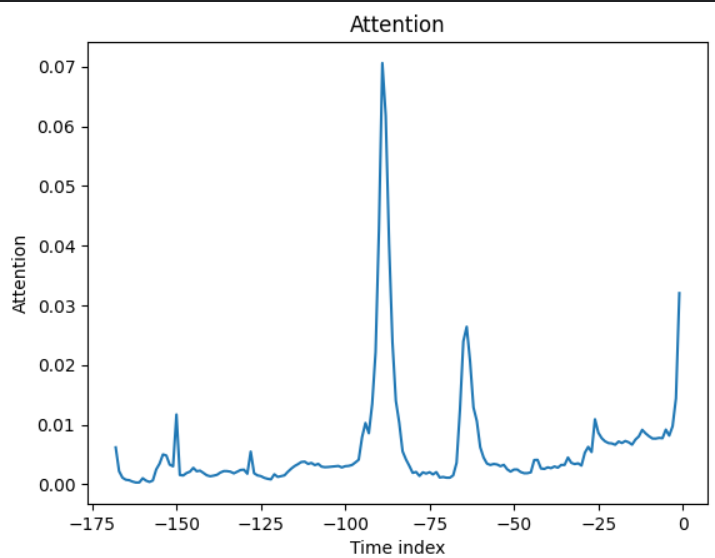

Key Time Points Identification: The graph reveals distinct spikes in attention at specific time indices, indicating that the model is particularly focused on certain past time steps. These key points likely contain critical information that heavily influences the model's predictions.

Temporal Pattern Recognition: The varying attention weights across different time indices suggest that the model is effectively recognizing and weighing the importance of temporal patterns in the data, rather than treating all time steps equally.

Feature Relevance and Model Focus: The most significant spike, around the -100 time index, indicates that the model considers this point crucial for decision-making, possibly due to important events or changes in the data occurring at this time.

Potential for Model Optimization: The areas of low or flat attention indicate time steps that contribute less to the model's predictions. These insights can guide further optimization, such as adjusting the model to focus more selectively on relevant time frames or refining input feature

## 5. Model Evaluation

In [45]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions
forecast_predictions = []
reconstruction_predictions = []

# Disable gradient computation during inference
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        
        # Forward pass to get predictions
        outputs_forecast, outputs_reconstruct = model(batch_X)
        
        # Store the predictions
        forecast_predictions.append(outputs_forecast.cpu().numpy())
        reconstruction_predictions.append(outputs_reconstruct.cpu().numpy())

# Convert the lists to numpy arrays
forecast_predictions = np.concatenate(forecast_predictions, axis=0)
reconstruction_predictions = np.concatenate(reconstruction_predictions, axis=0)


## 5. Making predictions

In [ ]:
# Set the model to evaluation mode
model.eval()

# Initialize lists to store predictions
forecast_predictions = []
reconstruction_predictions = []

# Disable gradient computation during inference
with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X = batch_X.to(device)
        
        # Forward pass to get predictions
        outputs_forecast, outputs_reconstruct = model(batch_X)
        
        # Store the predictions
        forecast_predictions.append(outputs_forecast.cpu().numpy())
        reconstruction_predictions.append(outputs_reconstruct.cpu().numpy())

# Convert the lists to numpy arrays
forecast_predictions = np.concatenate(forecast_predictions, axis=0)
reconstruction_predictions = np.concatenate(reconstruction_predictions, axis=0)



In [49]:
forecast_predictions

array([[ 3.24177265e-01,  4.89200279e-03,  1.25238765e-02, ...,
         3.11900899e-02,  3.40949744e-04,  2.91559118e-05],
       [ 5.28112315e-02, -1.04174018e-03,  3.78753059e-03, ...,
         5.49742818e-01,  3.49769369e-04, -3.00673622e-04],
       [ 1.96051389e-01,  9.52732265e-02,  1.14615358e-01, ...,
         3.26628745e-01,  1.12659298e-03, -2.19842914e-04],
       ...,
       [ 1.24525696e-01,  7.47197121e-02,  8.64674821e-02, ...,
         1.44203842e-01,  1.24730566e-03, -1.69205974e-04],
       [ 7.29934201e-02,  7.68148154e-02,  8.20176527e-02, ...,
         5.86953796e-02, -1.49031170e-04,  2.81996268e-04],
       [ 1.82755619e-01,  1.16476677e-01,  1.40137002e-01, ...,
         3.57058823e-01,  1.57768838e-04, -2.76836479e-04]], dtype=float32)

In [17]:
import torch
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np

# Set the model to evaluation mode
model.eval()

# Store predictions and true values
all_predictions = []
all_targets = []

with torch.no_grad():
    for batch_X, batch_y in test_loader:
        batch_X, batch_y = batch_X.to(device), batch_y.to(device)
        outputs = model(batch_X)
        all_predictions.append(outputs.cpu().numpy())
        all_targets.append(batch_y.cpu().numpy())

# Concatenate all batches
all_predictions = np.concatenate(all_predictions, axis=0)
all_targets = np.concatenate(all_targets, axis=0)

# Calculate metrics
mse = mean_squared_error(all_targets, all_predictions)
mae = mean_absolute_error(all_targets, all_predictions)

#  Make predictions
predictions = np.array(predictions)
actuals = np.array(actuals)

# Calculate Mean Absolute Error (MAE) for each feature
mae = np.mean(np.abs(predictions - actuals), axis=0)

print("Mean Absolute Error for each feature:")
for i, column in enumerate(preprocessed_df.columns[:-1]): 
    print(f"{column}: {mae[i]:.4f}")

Mean Absolute Error for each feature:
0: 0.0110
1: 0.0107
2: 0.0049
3: 0.0026
4: 0.0034
5: 0.0099
6: 0.0090
7: 0.0002
8: 0.0070
9: 0.0008
10: 0.0088
11: 0.0155
12: 0.0065
13: 0.0167
14: 0.0147
15: 0.0155
16: 0.0003
17: 0.0005
18: 0.0158
19: 0.0145
20: 0.0180
21: 0.0172
22: 0.0216
23: 0.0089
24: 0.0253
25: 0.0152
26: 0.0003
27: 0.0195
28: 0.0002
29: 0.0067
30: 0.0219
31: 0.0132
32: 0.0358
33: 0.0104
34: 0.0182
35: 0.0182
36: 0.0003
37: 0.0002


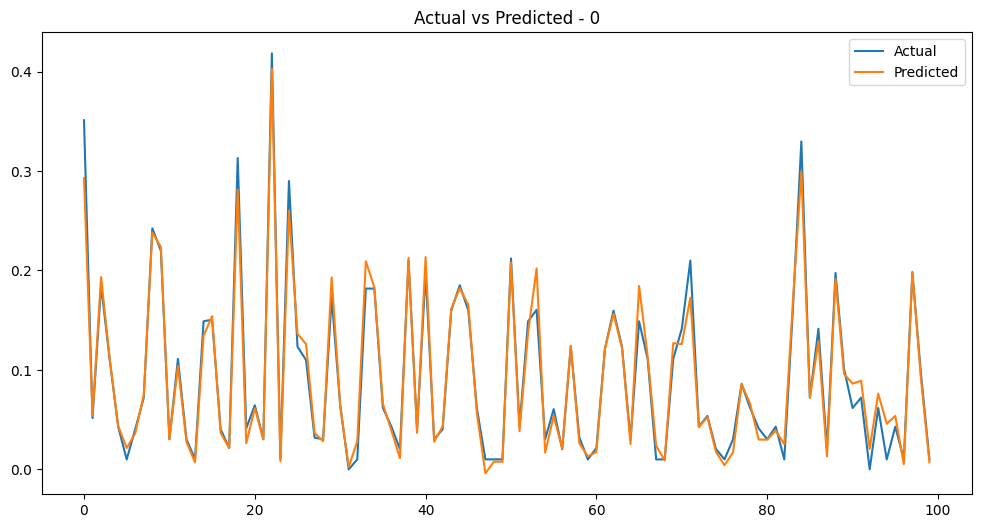

In [20]:
# Visualize predictions vs actuals for a single feature
import matplotlib.pyplot as plt

feature_to_plot = 0 
plt.figure(figsize=(12, 6))
plt.plot(actuals[:100, feature_to_plot], label='Actual')
plt.plot(predictions[:100, feature_to_plot], label='Predicted')
plt.legend()
plt.title(f"Actual vs Predicted - {preprocessed_df.columns[feature_to_plot]}")
plt.show()

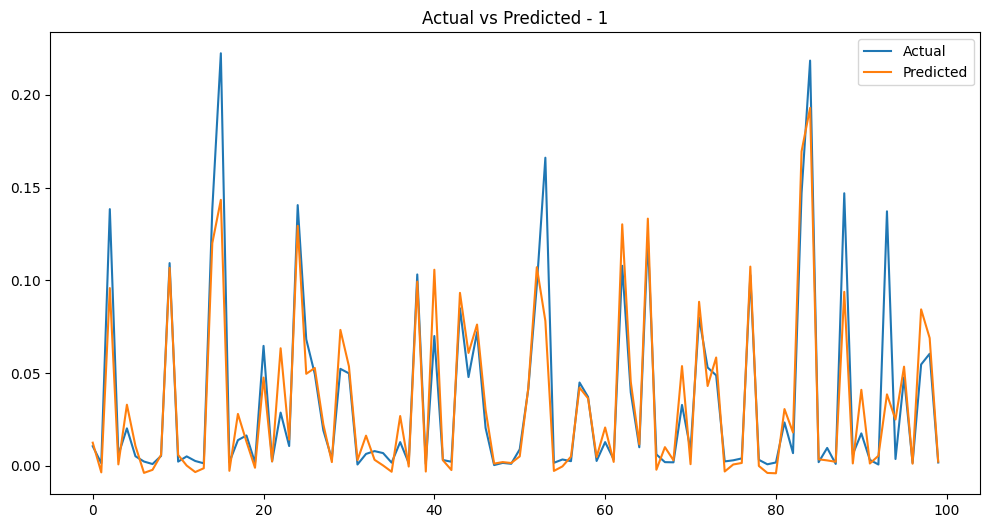

In [21]:
# Visualize predictions vs actuals for a single feature


feature_to_plot = 1
plt.figure(figsize=(12, 6))
plt.plot(actuals[:100, feature_to_plot], label='Actual')
plt.plot(predictions[:100, feature_to_plot], label='Predicted')
plt.legend()
plt.title(f"Actual vs Predicted - {preprocessed_df.columns[feature_to_plot]}")
plt.show()